In [1]:
#Here we're going to look at some powerful tools for selecting our signal from
#the background. In particular, a machine learning algorithm called a boosted
#decision tree using the xgboost package

import xgboost

In [2]:
#This just gives us some data to play with, you should use data from the sets
#you'd like to analyses. To train the algorithm we need some examples of
#things that looks like the signal, and examples of things that look like the
#background

import toydata
sig = toydata.getSignalData()
bkg = toydata.getBackgroundData()
list(sig)

['var1', 'var2', 'var3', 'var4', 'var5']

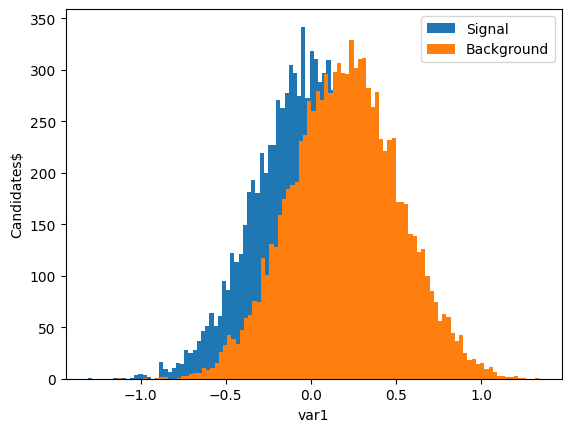

In [3]:
#Let's look at how separating var1 is between the two samples

from matplotlib import pyplot as plt 
plt.hist(sig['var1'], bins=100, label='Signal')
plt.hist(bkg['var1'], bins=100, label='Background')
plt.xlabel(r'var1')
plt.ylabel(r'Candidates$')
plt.legend()
plt.show()

In [4]:
#Clearly one can pick regions with different signal-to-background ratios
#by selecting some value of var1 and rejecting others.
#For example, if we rejected values of var1 greater than 0

nSignalTotal = sig['var1'].count()
nBackgroundTotal = bkg['var1'].count()
nSignalSelected = sig[sig['var1'] <= 0]['var1'].count()
nBackgroundSelected = bkg[bkg['var1'] <= 0]['var1'].count()

print('Signal Efficiency     = {}%'.format(100*nSignalSelected/nSignalTotal))
print('Background Efficiency = {}%'.format(100*nBackgroundSelected/nBackgroundTotal))

Signal Efficiency     = 49.95%
Background Efficiency = 26.32%


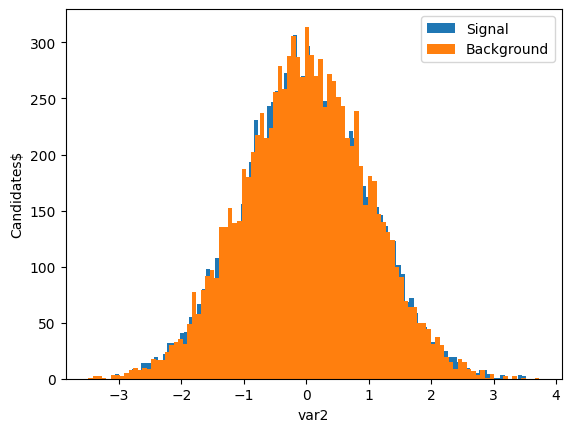

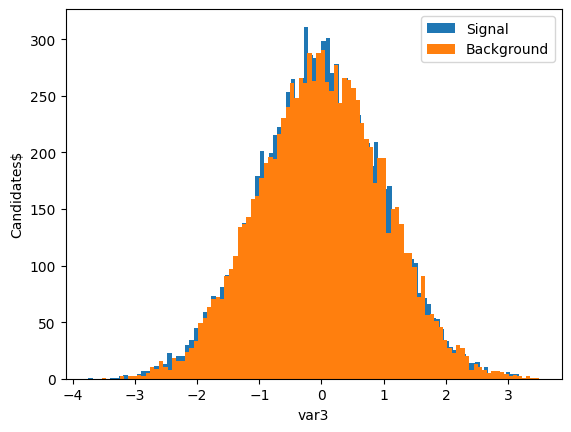

In [5]:
#We can look at some of the other variables. e.g. var2 and var3

plt.hist(sig['var2'], bins=100, label='Signal')
plt.hist(bkg['var2'], bins=100, label='Background')
plt.xlabel(r'var2')
plt.ylabel(r'Candidates$')
plt.legend()
plt.show()
plt.hist(sig['var3'], bins=100, label='Signal')
plt.hist(bkg['var3'], bins=100, label='Background')
plt.xlabel(r'var3')
plt.ylabel(r'Candidates$')
plt.legend()
plt.show()

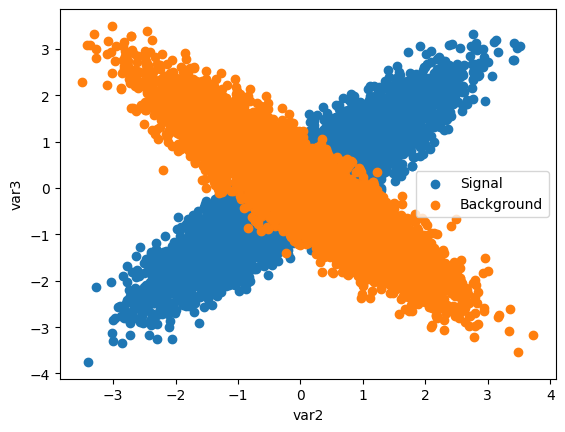

In [6]:
#This doesn't look great, they are on top of each other. There appears to be no
#separating power, but let's look in 2D

plt.scatter(sig['var2'], sig['var3'], label='Signal')
plt.scatter(bkg['var2'], bkg['var3'], label='Background')
plt.xlabel(r'var2')
plt.ylabel(r'var3')
plt.legend()
plt.show()

In [7]:
#Clearly there are now regions where you can get an almost perfect separation
#when treating the problem multidimensionality.

#In general, the problem requires finding the best regions in a
#multidimensional space to select as much signal as possible while rejecting
#as much background. This is not easy, but luckily we have machine learning
#algorithms to deal with it.

#We will use a boosted decision tree. This creates a tree with each node trying
#to maximise the signal-to-background ratio with a simple splitting in one
#variable. If a node reaches some purity threshold it becomes a leaf, otherwise
#further splitting is applied. In this way one achieves a weak classifier.
#Boosting is a method to adjust the importance of misclassified events, to
#improve the performance of a newly trained tree. While each tree trained this
#way is a weak classifier, the collection of trees can be very powerful.

In [8]:
#We will create a classifier.
#We will use the Area Under the Curve (AUC) as the figure of merit for training
#our classifier. The curve refered to is the ROC curve discussed later.
#We will stop the training early if there is no improvement for 50 trained trees
#We will train a maximum of 1000 trees (it may stop early as above)
#We will set the learning rate (how strongly the boosting attempts to correct)
#the misclassified events to 0.3
#We will set the maximum levels of splittings to 6

#NB. There are also other parameters that control the training. The values chosen are
#just to give an example of a sensible training, and are unlikely to be the ones
#that give the optimal performance. These are known as hyperparameters, and it
#is a task in itself to find the most appropriate values for them

model = xgboost.XGBClassifier(eval_metric='auc', early_stopping_rounds=50, n_estimators=1000, learning_rate=0.3, max_depth=6)

In [9]:
#The classifier needs to be given a set of data to train on, and a sample used to
#test the performance of the algorithm. It is best to make these two samples
#statistically independent. We will use 90% of our data as the training sample
#and 10% as the testing/evaluation sample. We also need to tell the algorithm
#what class an event really belongs to. We will use Signal=1 and Background=0

nSignalTrain = int(0.9*nSignalTotal)
nSignalTest  = nSignalTotal - nSignalTrain
nBackgroundTrain = int(0.9*nBackgroundTotal)
nBackgroundTest  = nBackgroundTotal - nBackgroundTrain

#x are the features and y are the classes
import pandas
x_train = pandas.concat([sig[:nSignalTrain], bkg[:nBackgroundTrain]], axis=0, ignore_index=True)
y_train = [1]*nSignalTrain + [0]*nBackgroundTrain

x_test = pandas.concat([sig[nSignalTrain:], bkg[nBackgroundTrain:]], axis=0, ignore_index=True)
y_test  = [1]*nSignalTest + [0]*nBackgroundTest

model.fit(x_train, y_train, eval_set=[(x_test,y_test)])

[0]	validation_0-auc:0.74815
[1]	validation_0-auc:0.89963
[2]	validation_0-auc:0.91811
[3]	validation_0-auc:0.92771
[4]	validation_0-auc:0.93039
[5]	validation_0-auc:0.93360
[6]	validation_0-auc:0.93790
[7]	validation_0-auc:0.94225
[8]	validation_0-auc:0.94478
[9]	validation_0-auc:0.94600
[10]	validation_0-auc:0.94729
[11]	validation_0-auc:0.94865
[12]	validation_0-auc:0.94881
[13]	validation_0-auc:0.94896
[14]	validation_0-auc:0.94914
[15]	validation_0-auc:0.95036
[16]	validation_0-auc:0.95086
[17]	validation_0-auc:0.95088
[18]	validation_0-auc:0.95136
[19]	validation_0-auc:0.95168
[20]	validation_0-auc:0.95185
[21]	validation_0-auc:0.95196
[22]	validation_0-auc:0.95209
[23]	validation_0-auc:0.95233
[24]	validation_0-auc:0.95263
[25]	validation_0-auc:0.95271
[26]	validation_0-auc:0.95281
[27]	validation_0-auc:0.95285
[28]	validation_0-auc:0.95258
[29]	validation_0-auc:0.95287
[30]	validation_0-auc:0.95295
[31]	validation_0-auc:0.95295
[32]	validation_0-auc:0.95297
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'auc'


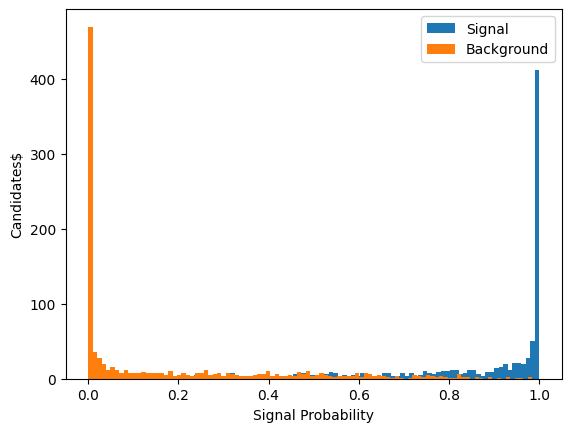

In [10]:
#We now have a classification algorithm. To see how well it works we can apply
#it to the test set. The following computes the "probability" of an event
#belonging to each class. We only care about the signal class (which was 1)

prediction = model.predict_proba(x_test)

plt.hist([p[1] for p,cls in zip(prediction, y_test) if cls == 1], bins=100, label='Signal')
plt.hist([p[1] for p,cls in zip(prediction, y_test) if cls == 0], bins=100, label='Background')
plt.xlabel(r'Signal Probability')
plt.ylabel(r'Candidates$')
plt.legend()
plt.show()

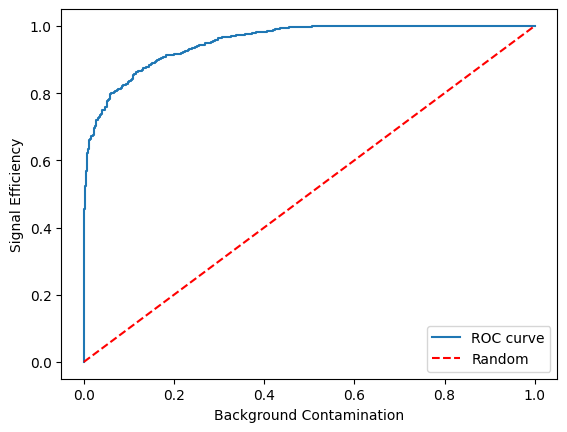

In [11]:
#This clearly is now a very separating value to make a selection on.
#We can look at the performance of the algorithm in different ways.
#The next is the ROC curve, this stands for receiver operating characteristic.
#Essentially for each value of signal probability it shows the signal and
#background efficiencies, the further into the corner the better. This
#is why we chose the area under this curve as the figure of merit to train
#against. 0.5 is no better than a coin flip, 1 is perfect separation

from sklearn.metrics import roc_curve
background_accepted, signal_accepted, probabilities_tested = roc_curve(y_test, prediction[:,1])
plt.plot(background_accepted, signal_accepted, label='ROC curve')
plt.plot([0,1], [0,1], color='red', linestyle='--', label = 'Random')
plt.xlabel(r'Background Contamination')
plt.ylabel(r'Signal Efficiency')
plt.legend()
plt.show()

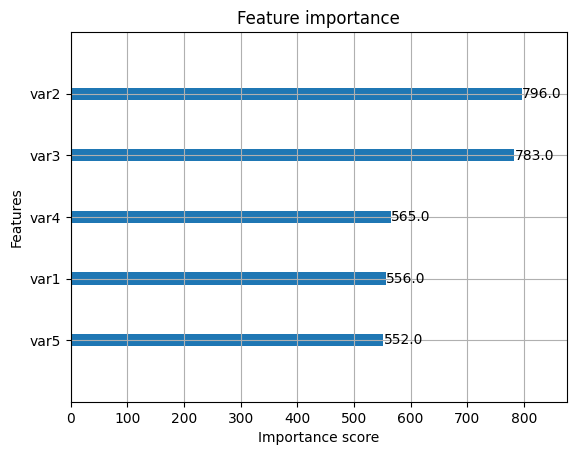

In [12]:
#Another useful diagnostic is to look at which of the variables are most useful
#in the clasificaton. Here it is academic, but it is important to think
#whether the relative importance makes sense. If not it could indicate
#something has gone wrong with the training

a = xgboost.plot_importance(model)

In [13]:
#We've used all the variables in the data as features in the algorithm. This is
#not a good idea as if they aren't separating, they just add noise and increase
#the dimensionality of the problem. Also, some may be separating, but for
#artificial reasons, e.g. if regions in the data were selected to provide a
#signal-like and background-like sample. Any features correlated with those
#used in that selection will be separating in the algorithm, but only because
#we introduced a separation with our method. So we want to pick the best set
#of features, but how do we do this?

#We also haven't tuned the hyperparameters. We've used some sensible ones, but
#there could be a more performant algorithm with a different set. How do we
#find it?

#Finally, we can use the signal prediction probability to enhance the signal
#to background ratio of our data. But what region should we pick? Ultimately
#we want something that gives us the best performance on what we're trying to
#measure.